# step 59 RNN을 활용한 시계열 데이터 처리

In [ ]:
import os, sys
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
my_path = '/content/notebooks'
# 구글드라이브 deep-learning-from-scratch-3-master 폴더에 있는 패키지를 colab에 심볼링크걸린 notebooks 폴더 생성 
os.symlink('/content/drive/MyDrive/Colab Notebooks/deep-learning-from-scratch-3-master', my_path)
# 파이썬 모듈 검색 경로추가
sys.path.insert(0, my_path)

### 499 그림

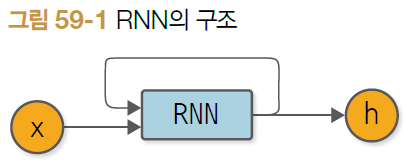

## 59.1 RNN 계층 구현

### 500 식

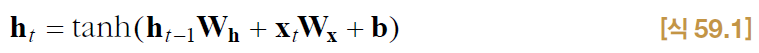

### 500~501 layers.py

In [ ]:
# dezero/layers.py

from dezero import Layer   # 실행하기 위해

class RNN(Layer):
  def __inti__(self, hidden_size, in_size=None):
    super().__init__()
    self.x2h = Linear(hidden_size, in_size=in_size)
    self.h2h = Linear(hidden_size, in_size=in_size, nobias=True)
    self.h = None

  def reset_state(self):
    self.h = None

  def forward(self, x):
    if self.h is None:
      h_new = F.tanh(self.x2h(x))
    else:
      h_new = F.tanh(self.x2h(x) + self.h2h(self.h))
    self.h = h_new
    return h_new

In [ ]:
import numpy as np
import dezero.layers as L

rnn = L.RNN(10)  # 은닉층의 크기만 지정
x = np.random.rand(1, 1)
h = rnn(x)
print(h.shape)

(1, 10)


### 502 그림

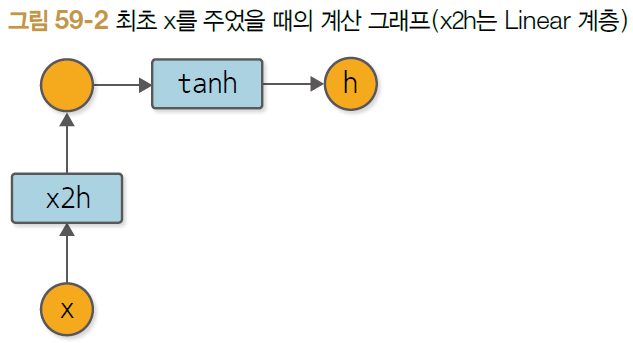

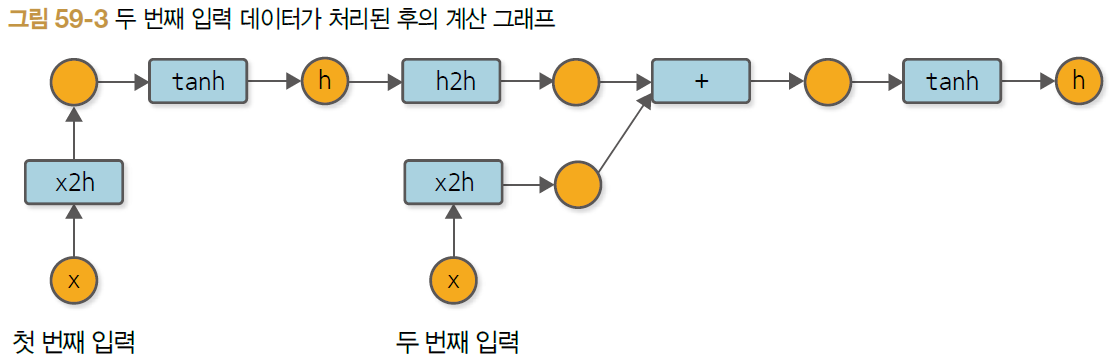

## 59.2 RNN 모델 구현

### 502~503 step59.py

In [ ]:
# steps/step59.py

from dezero import Model
import dezero.functions as F
import dezero.layers as L

class SimpleRNN(Model):
  def __init__(self, hidden_size, out_size):
    super().__init__()
    self.rnn = L.RNN(hidden_size)
    self.fc = L.Linear(out_size)

  def reset_state(self):
    self.rnn.reset_state()

  def forward(self, x):
    h = self.rnn(x)
    y = self.fc(h)
    return y

### 503~504

In [ ]:
seq_data = [np.random.randn(1, 1) for _ in range(1000)]  # 더미 시계열 데이터
xs = seq_data[0:-1]
ts = seq_data[1:]  # 정답 데이터: xs보다 한 단계 앞서너 데이터

model = SimpleRNN(10, 1)

loss, cnt = 0, 0
for x, t in zip(xs, ts):
  y = model(x)
  loss += F.mean_squared_error(y, t)
  cnt += 1
  if cnt == 2:
    model.cleargrads()
    loss.backward()
    break


### 504~505 그림

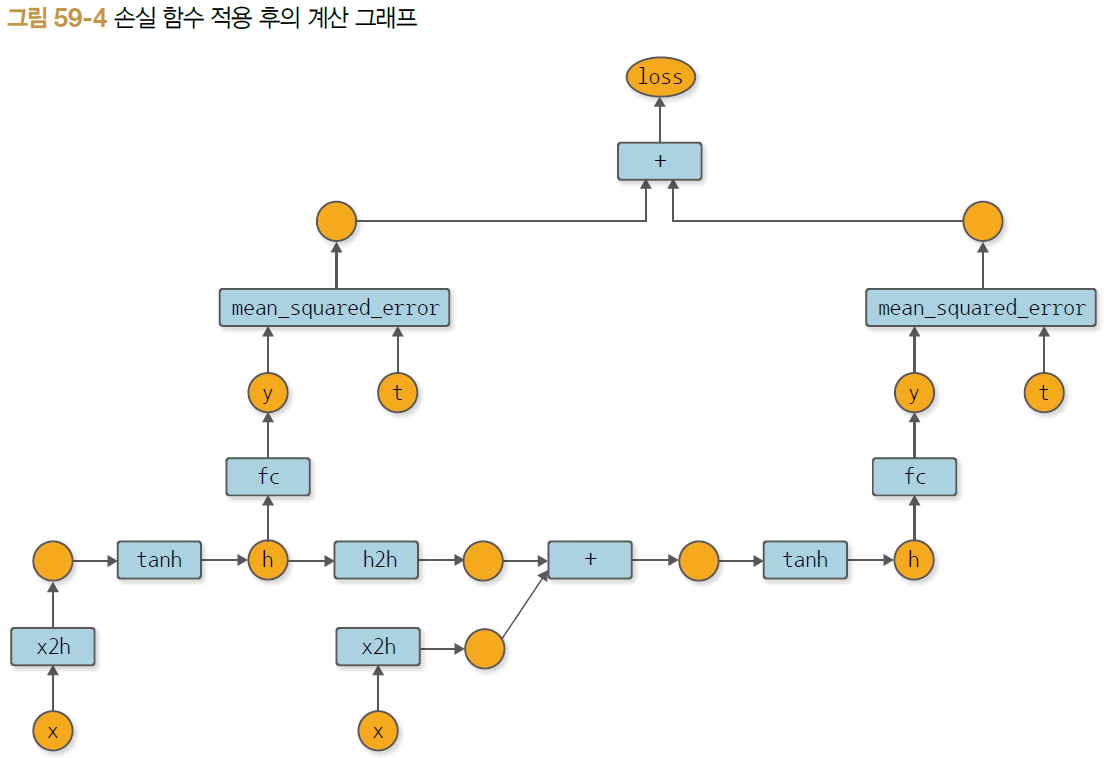

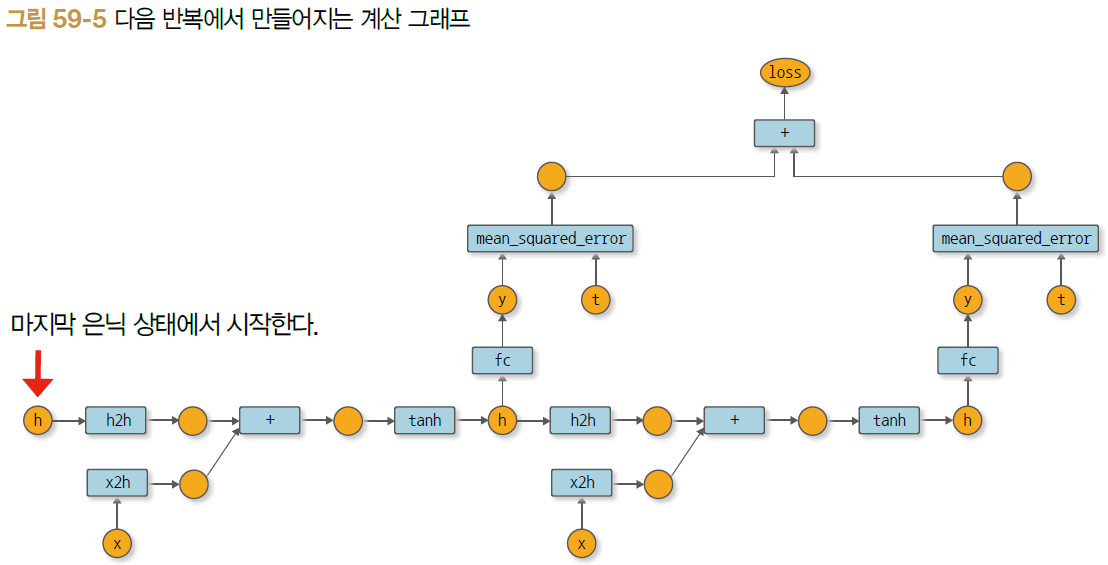

## 59.3 '연결'을 끊어주는 메서드

### 506 core.py

In [ ]:
# dezero/core.py

class Variable:
  ### ...

  def unchain(self):
    self.creator = None

In [ ]:
# dezero/core.py

class Variable:
  ### ...

  def unchain_backward(self):
    if self.creator is not None:
      funcs = [self.creator]
      while funcs:
        f = funcs.pop()
        for x in f.inputs:
          if x.creator is not None:
            funcs.append(x.creatro)
            x.unchain()

## 59.4 사인파 예측

### 507~508

999
(array([-0.01008047]), array([-0.00783049]))
(array([-0.00783049]), array([-0.02635981]))
(array([-0.02635981]), array([0.01607609]))


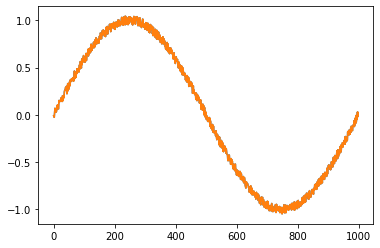

In [ ]:
import numpy as np
import dezero
import matplotlib.pyplot as plt

train_set = dezero.datasets.SinCurve(train=True)
print(len(train_set))
print(train_set[0])
print(train_set[1])
print(train_set[2])

# 그래프 그리기
xs = [example[0] for example in train_set]
ts = [example[0] for example in train_set]
plt.plot(np.arange(len(xs)), xs, label='xs')
plt.plot(np.arange(len(ts)), ts, label='ts')
plt.show()

### 508~509 step59.py

In [ ]:
# steps/step59.py

# 하이퍼파라미터 설정

max_epoch = 100
hidden_size = 100
bptt_length = 30  # BPTT 길이
train_set = dezero.datasets.SinCurve(train=True)
seqlen = len(train_set)

model = SimpleRNN(hidden_size, 1)
optimizer = dezero.optimizers.Adam().setup(model)

# 학습 시작
for epoch in range(max_epoch):
  model.reset_state()
  loss, count = 0, 0

  for x, t in train_set:
    x = x.reshape(1, 1)  # 형상을 (1, 1)로 변환 # 추가
    y = model(x)
    loss += F.mean_squared_error(y, t)
    count += 1

    # Truncated BPTT의 타이밍 조정
    if count % bptt_length == 0 or count == seqlen:  # 추가
      model.cleargrads()
      loss.backward()
      loss.unchain_backward()  # 연결 끊기 # 추가
      optimizer.update()

  avg_loss = float(loss.data) / count
  print('| epoch %d | loss %f' % (epoch + 1, avg_loss))

| epoch 1 | loss 0.226108
| epoch 2 | loss 0.038371
| epoch 3 | loss 0.012774
| epoch 4 | loss 0.005753
| epoch 5 | loss 0.003823
| epoch 6 | loss 0.002312
| epoch 7 | loss 0.002412
| epoch 8 | loss 0.001783
| epoch 9 | loss 0.002395
| epoch 10 | loss 0.003099
| epoch 11 | loss 0.004905
| epoch 12 | loss 0.006516
| epoch 13 | loss 0.005512
| epoch 14 | loss 0.004109
| epoch 15 | loss 0.003910
| epoch 16 | loss 0.004659
| epoch 17 | loss 0.005683
| epoch 18 | loss 0.005919
| epoch 19 | loss 0.005160
| epoch 20 | loss 0.004422
| epoch 21 | loss 0.004258
| epoch 22 | loss 0.004533
| epoch 23 | loss 0.004898
| epoch 24 | loss 0.005001
| epoch 25 | loss 0.004754
| epoch 26 | loss 0.004396
| epoch 27 | loss 0.004176
| epoch 28 | loss 0.004165
| epoch 29 | loss 0.004252
| epoch 30 | loss 0.004275
| epoch 31 | loss 0.004232
| epoch 32 | loss 0.004113
| epoch 33 | loss 0.003967
| epoch 34 | loss 0.003860
| epoch 35 | loss 0.003813
| epoch 36 | loss 0.003801
| epoch 37 | loss 0.003790
| epoch 38

### 510 step59.py

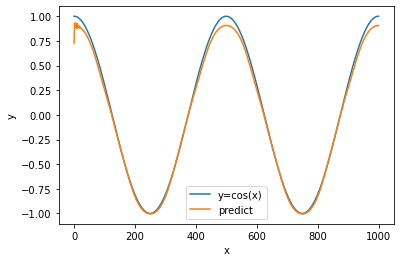

In [ ]:
# steps/step59.py

import matplotlib.pyplot as plt

xs = np.cos(np.linspace(0, 4 * np.pi, 1000))
model.reset_state()  # 모델 재설정
pred_list = []

with dezero.no_grad():
  for x in xs:
    x = np.array(x).reshape(1, 1)
    y = model(x)
    pred_list.append(float(y.data))

plt.plot(np.arange(len(xs)), xs, label='y=cos(x)')
plt.plot(np.arange(len(xs)), pred_list, label='predict')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()